# <b> <font color = 'orange'>Importing Libraries

In [1]:
import time
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import StaleElementReferenceException, TimeoutException
from tqdm import tqdm

# <b> <font color = 'orange'>User-defined function to scrape product details from Myntra.

In [2]:
def get_product_details(url: str, keyword: str, limit: int = 10) -> pd.DataFrame:
    # Initialize lists
    product_type = []
    product_brand = []
    product_price = []
    product_rating = []
    total_rating = []

    try:
        driver = webdriver.Chrome()
        driver.get(url)

        # Wait for the search box and interact with it
        search_box = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'desktop-query'))
        )
        search_bar = search_box.find_element(By.CLASS_NAME, 'desktop-searchBar')
        search_bar.send_keys(keyword)

        search_button = search_box.find_element(By.CLASS_NAME, 'desktop-submit')
        search_button.click()

        # Wait for products to load
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CLASS_NAME, 'product-base'))
        )

        for _ in tqdm(range(limit)):  # Iterate through multiple pages
            
            # Fetch fresh elements each loop to prevent stale reference
            try:
                WebDriverWait(driver, 10).until(
                    EC.presence_of_all_elements_located((By.CLASS_NAME, 'product-base'))
                )
                product_data = driver.find_elements(By.CLASS_NAME, 'product-base')

                for data in product_data:
                    try:
                        # Extract product type
                        prod_type = data.find_elements(By.CLASS_NAME, 'product-product')
                        product_type.append(prod_type[0].text if prod_type else "Unknown")

                        # Extract brand name
                        brand_name = data.find_elements(By.CLASS_NAME, 'product-brand')
                        product_brand.append(brand_name[0].text if brand_name else "Unknown")

                        # Extract and clean product price
                        prod_price = data.find_elements(By.CLASS_NAME, 'product-price')
                        if prod_price:
                            price_text = prod_price[0].text.replace('Rs', '').replace('.', '').strip()
                            price_numbers = re.findall(r'\d+', price_text)
                            price = int(price_numbers[0]) if price_numbers else 0
                        else:
                            price = 0
                        product_price.append(price)

                        # Extract product rating
                        prod_rating = data.find_elements(By.CLASS_NAME, 'product-ratingsContainer')
                        product_rating.append(prod_rating[0].text.split('\n')[0] if prod_rating else "No Rating")

                        # Extract total rating count
                        total_rate = data.find_elements(By.CLASS_NAME, 'product-ratingsCount')
                        if total_rate:
                            rate_text = total_rate[0].text.split('\n')
                            total_rating.append(rate_text[1] if len(rate_text) > 1 else "0")
                        else:
                            total_rating.append("0")

                    except StaleElementReferenceException:
                        print("⚠️ Stale element detected. Skipping this product.")
                        continue  # Skip this element and move to the next

            except TimeoutException:
                print("⚠️ Products did not load in time. Exiting loop.")
                break  # Stop if products are not loading

            # Pagination Handling (Click Next Button)
            try:
                next_button = WebDriverWait(driver, 5).until(
                    EC.element_to_be_clickable((By.CLASS_NAME, 'pagination-next'))
                )
                driver.execute_script("arguments[0].scrollIntoView();", next_button)  # Scroll to button
                time.sleep(1)  # Small delay for smooth scrolling
                driver.execute_script("arguments[0].click();", next_button)  # Click using JavaScript
                time.sleep(2)  # Wait for the next page to load
            except TimeoutException:
                print("✅ No more pages to scrape or next button not found.")
                break  # Exit loop if next bu-tton is not available

    except Exception as e:
        print(f"❌ Error occurred: {e}")

    finally:
        driver.quit()  # Ensure driver is closed properly

    # Convert collected data into a Pandas DataFrame
    data = {
        'product_type': product_type,
        'brand': product_brand,
        'price': product_price,
        'rating': product_rating,
        'total_rating': total_rating
    }
    df = pd.DataFrame(data)
    return df

In [3]:
url: str = "https://www.myntra.com/"
keyword: str = "kurta for men"
limit: int = 20

In [4]:
df = get_product_details(url, keyword, limit)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:36<00:00, 10.83s/it]


# <b> <font color = 'orange'>Data Pre-processing

In [5]:
df.head()

,product_type,brand,price,rating,total_rating
0,Embroidered Cotton Silk Kurta,Jompers,962,4,1.3k
1,Men Kurta,HERE&NOW,797,4.4,5.3k
2,Mandarin Collar Kurtas,KISAH,2499,3.6,16
3,Embroidered Straight Kurta,Anouk,971,4.2,140
4,Embroidered Pure Cotton Kurta,Jompers,935,4.2,3k


In [6]:
df['total_rating'].unique()

array(['1.3k', '5.3k', '16', '140', '3k', '86', '5.5k', '12', '0', '8.1k',
       '93', '44', '4.8k', '2.9k', '15', '100', '489', '6.1k', '2.4k',
       '4k', '9', '388', '23', '5.1k', '2.7k', '189', '583', '823', '360',
       '717', '5', '7.8k', '87', '2.6k', '827', '1.4k', '75', '223',
       '228', '262', '8k', '20', '831', '32', '7.3k', '161', '710', '474',
       '265', '171', '240', '57', '1.5k', '99', '700', '237', '165',
       '392', '383', '177', '10', '120', '76', '64', '257', '116', '641',
       '954', '263', '34', '470', '362', '8', '104', '62', '41', '1.9k',
       '81', '428', '425', '622', '473', '600', '331', '589', '113',
       '393', '170', '3.6k', '1.8k', '854', '163', '440', '797', '2.5k',
       '3.3k', '3.8k', '381', '25', '335', '144', '508', '6', '107', '49',
       '18', '403', '80', '505', '22', '59', '24', '256', '173', '688',
       '137', '278', '958', '50', '14', '404', '486', '394', '999', '214',
       '19', '74', '525', '308', '220', '203', '1.1k', 

In [7]:
df['total_rating'] = df['total_rating'].apply(lambda s: s.replace('k', '00') if '.' in s else s.replace('k', '000'))

In [8]:
df['total_rating'].unique()

array(['1.300', '5.300', '16', '140', '3000', '86', '5.500', '12', '0',
       '8.100', '93', '44', '4.800', '2.900', '15', '100', '489', '6.100',
       '2.400', '4000', '9', '388', '23', '5.100', '2.700', '189', '583',
       '823', '360', '717', '5', '7.800', '87', '2.600', '827', '1.400',
       '75', '223', '228', '262', '8000', '20', '831', '32', '7.300',
       '161', '710', '474', '265', '171', '240', '57', '1.500', '99',
       '700', '237', '165', '392', '383', '177', '10', '120', '76', '64',
       '257', '116', '641', '954', '263', '34', '470', '362', '8', '104',
       '62', '41', '1.900', '81', '428', '425', '622', '473', '600',
       '331', '589', '113', '393', '170', '3.600', '1.800', '854', '163',
       '440', '797', '2.500', '3.300', '3.800', '381', '25', '335', '144',
       '508', '6', '107', '49', '18', '403', '80', '505', '22', '59',
       '24', '256', '173', '688', '137', '278', '958', '50', '14', '404',
       '486', '394', '999', '214', '19', '74', '525', '3

In [9]:
df['total_rating'] = df['total_rating'].str.replace('.','')

In [10]:
df['total_rating'] = df['total_rating'].astype('int')

In [11]:
df.head()

,product_type,brand,price,rating,total_rating
0,Embroidered Cotton Silk Kurta,Jompers,962,4,1300
1,Men Kurta,HERE&NOW,797,4.4,5300
2,Mandarin Collar Kurtas,KISAH,2499,3.6,16
3,Embroidered Straight Kurta,Anouk,971,4.2,140
4,Embroidered Pure Cotton Kurta,Jompers,935,4.2,3000


In [12]:
df['rating'].unique()

array(['4', '4.4', '3.6', '4.2', '4.6', '4.1', '3.7', '3.5', 'No Rating',
       '4.3', '3.8', '3.3', '3.9', '3.2', '4.8', '4.5', '2.8', '3.4',
       '1.8', '5', '3.1', '2.9', '4.7', '2.6', '2.3', '4.9'], dtype=object)

In [13]:
df['rating'].value_counts()

rating
4.2          197
No Rating    164
4.1          135
4.3          113
4.4           76
4             69
3.9           68
3.8           32
4.5           28
3.7           22
4.6           19
3.5           17
3.6           15
3.3            9
5              6
4.8            5
3.4            4
3.2            3
2.9            3
3.1            3
4.9            3
2.8            2
2.6            2
4.7            2
2.3            2
1.8            1
Name: count, dtype: int64

In [14]:
df.dtypes

product_type    object
brand           object
price            int64
rating          object
total_rating     int64
dtype: object

In [15]:
df.loc[df['rating'] == 'No Rating', 'rating'] = '0'

In [16]:
df['rating'].value_counts()

rating
4.2    197
0      164
4.1    135
4.3    113
4.4     76
4       69
3.9     68
3.8     32
4.5     28
3.7     22
4.6     19
3.5     17
3.6     15
3.3      9
5        6
4.8      5
3.4      4
3.2      3
2.9      3
3.1      3
4.9      3
2.8      2
2.6      2
4.7      2
2.3      2
1.8      1
Name: count, dtype: int64

In [17]:
df['rating'] = df['rating'].astype('float')

In [18]:
df['rating'].dtype

dtype('float64')

In [19]:
df.dtypes

product_type     object
brand            object
price             int64
rating          float64
total_rating      int64
dtype: object

# <b> <font color = 'orange'>EDA `(Exploratory Data Analysis)`

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_type  1000 non-null   object 
 1   brand         1000 non-null   object 
 2   price         1000 non-null   int64  
 3   rating        1000 non-null   float64
 4   total_rating  1000 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB


In [21]:
print(df.duplicated().sum())

94


In [22]:
df.shape

(1000, 5)

In [23]:
df.drop_duplicates(keep = 'first', inplace=True)

In [24]:
df.shape

(906, 5)

In [25]:
df.isnull().sum()

product_type    0
brand           0
price           0
rating          0
total_rating    0
dtype: int64

In [26]:
df.corr(numeric_only=True)

,price,rating,total_rating
price,1.00000,-0.058390,-0.082070
rating,-0.05839,1.000000,0.194312
total_rating,-0.08207,0.194312,1.000000


In [27]:
df['brand'].value_counts()

brand
Anouk                177
SOJANYA              136
Jompers              104
HERE&NOW              63
Diwas by Manyavar     40
                    ... 
Enchanted Drapes       1
ARMISTO                1
John Philips           1
univibe                1
MANQ                   1
Name: count, Length: 79, dtype: int64

In [28]:
brand_counts = df["brand"].value_counts()

In [29]:
df["brand"] = df["brand"].where(df["brand"].map(brand_counts) >= 9, "Other Brand")

In [30]:
df['brand'].value_counts()

brand
Other Brand               177
Anouk                     177
SOJANYA                   136
Jompers                   104
HERE&NOW                   63
Diwas by Manyavar          40
House of Pataudi           36
Sangria                    32
See Designs                26
VASTRAMAY                  23
Taavi                      16
DENNISON                   16
FUBAR                      16
Vida Loca                  12
Latest Chikan Garments     12
Majestic Man               11
SOJANYA PLUS                9
Name: count, dtype: int64

# <b> <font color = 'orange'>Ploting : `Data Visualization`

In [31]:
df.head()

,product_type,brand,price,rating,total_rating
0,Embroidered Cotton Silk Kurta,Jompers,962,4.0,1300
1,Men Kurta,HERE&NOW,797,4.4,5300
2,Mandarin Collar Kurtas,Other Brand,2499,3.6,16
3,Embroidered Straight Kurta,Anouk,971,4.2,140
4,Embroidered Pure Cotton Kurta,Jompers,935,4.2,3000


In [32]:
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_theme()

In [33]:
df.shape

(906, 5)

In [34]:
df1 = df.groupby('brand')['rating'].mean().sort_values(ascending=False)
df1 = df1.to_frame().reset_index()

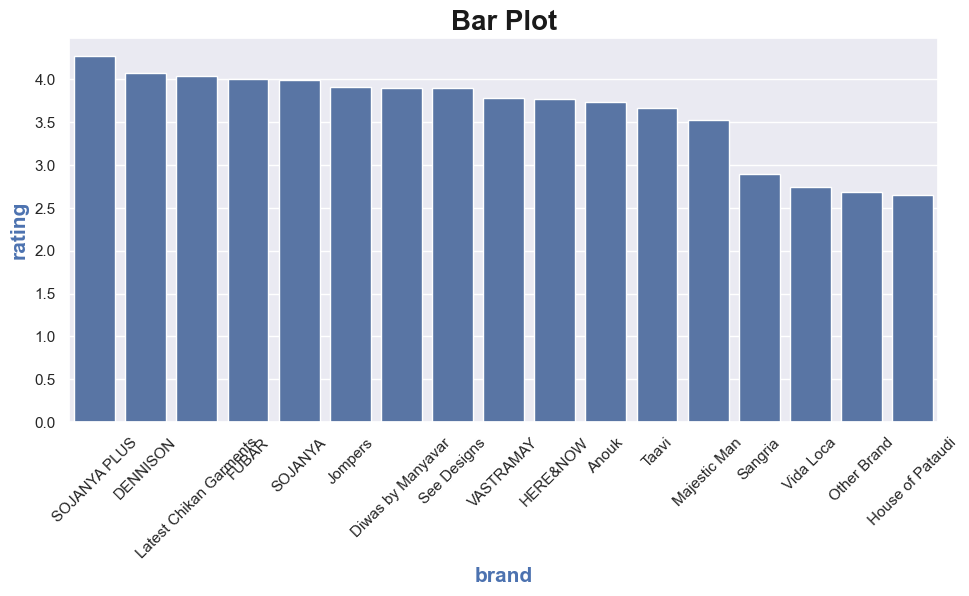

In [35]:
plt.figure(figsize=(10, 5))
sns.barplot(data = df1, x=df1['brand'], y=df1['rating'])
plt.title("Bar Plot",fontdict={'fontsize':20,'fontweight':'bold','color':'k'})
plt.ylabel(df1.columns[1],fontdict={'fontsize':15,'fontweight':'bold','color':'b'})
plt.xlabel(df1.columns[0],fontdict={'fontsize':15,'fontweight':'bold','color':'b'})
plt.tight_layout()
plt.xticks(rotation = 45)
plt.show()

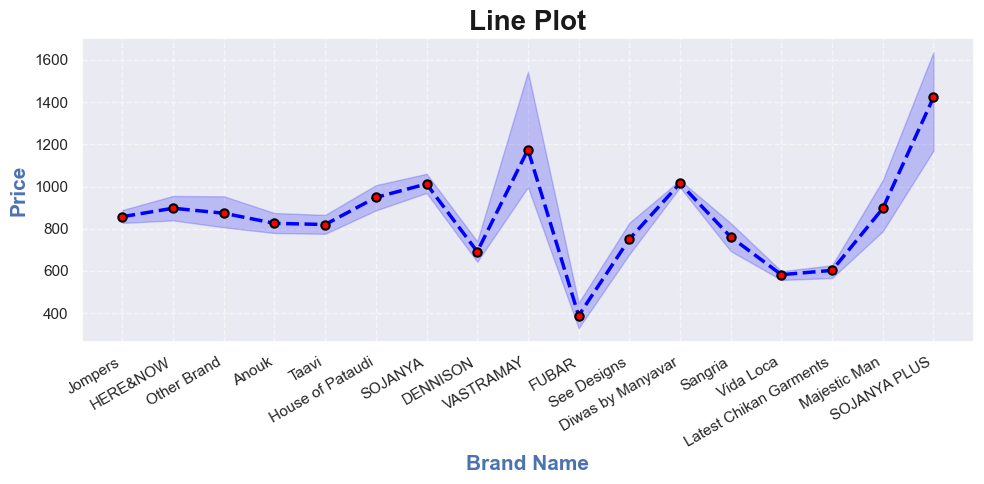

In [36]:
plt.figure(figsize=(10, 5))

sns.lineplot(
    x=df['brand'], 
    y=df['price'], 
    marker="o",         
    linestyle="dashed", 
    linewidth=2.5,      
    color="blue",      
    markerfacecolor="red", 
    markeredgewidth=1.5,  
    markeredgecolor="black"
)

plt.title("Line Plot", fontdict={'fontsize': 20, 'fontweight': 'bold', 'color': 'k'})
plt.xlabel("Brand Name", fontdict={'fontsize': 15, 'fontweight': 'bold', 'color': 'b'})
plt.ylabel("Price", fontdict={'fontsize': 15, 'fontweight': 'bold', 'color': 'b'})

plt.xticks(rotation=30, ha='right')

plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

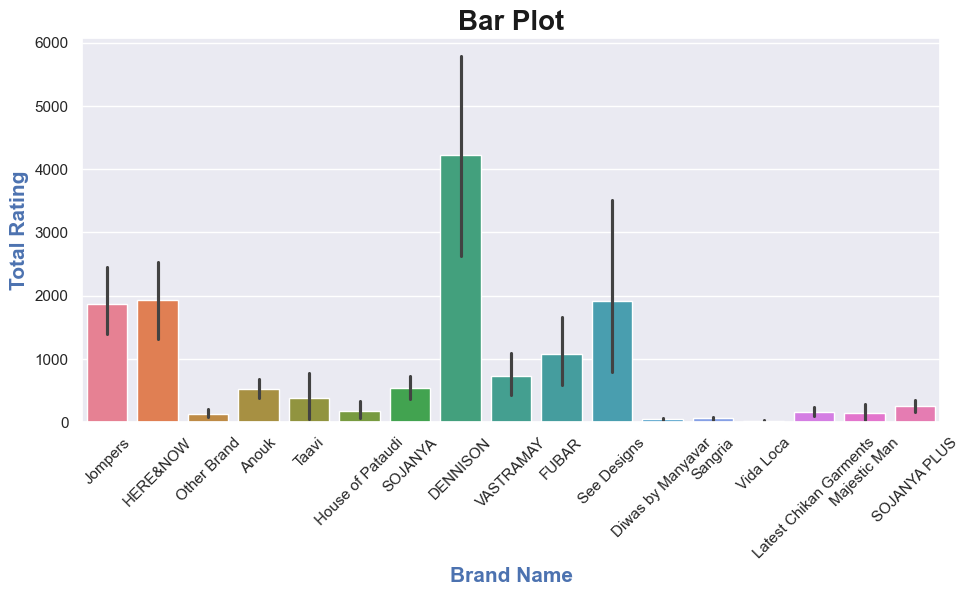

In [37]:
plt.figure(figsize=(10, 5))
sns.barplot(data = df, x='brand', y='total_rating', hue = 'brand')
plt.title("Bar Plot",fontdict={'fontsize':20,'fontweight':'bold','color':'k'})
plt.ylabel('Total Rating',fontdict={'fontsize':15,'fontweight':'bold','color':'b'})
plt.xlabel('Brand Name',fontdict={'fontsize':15,'fontweight':'bold','color':'b'})
plt.tight_layout()
plt.xticks(rotation = 45)
plt.show()

In [38]:
df.head()

,product_type,brand,price,rating,total_rating
0,Embroidered Cotton Silk Kurta,Jompers,962,4.0,1300
1,Men Kurta,HERE&NOW,797,4.4,5300
2,Mandarin Collar Kurtas,Other Brand,2499,3.6,16
3,Embroidered Straight Kurta,Anouk,971,4.2,140
4,Embroidered Pure Cotton Kurta,Jompers,935,4.2,3000


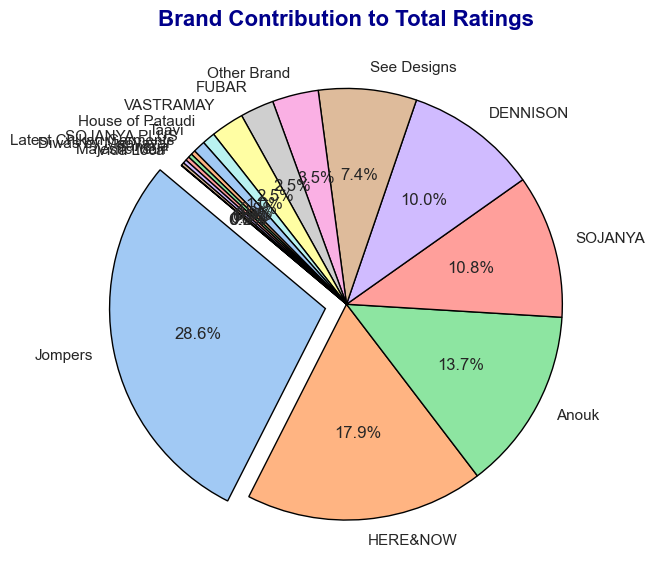

In [39]:
grouped_data = grouped_data = df.groupby('brand')['total_rating'].sum().sort_values(ascending = False)

colors = sns.color_palette("pastel", len(grouped_data))

explode = [0.1 if i == 0 else 0 for i in range(len(grouped_data))]  

plt.figure(figsize=(10, 6))
plt.pie(
    grouped_data.values, 
    labels=grouped_data.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors, 
    explode=explode, 
    wedgeprops={'edgecolor': 'black'}
)

plt.title("Brand Contribution to Total Ratings", fontsize=16, fontweight='bold', color='darkblue')
plt.tight_layout()
plt.show()